# Anomaly detection for time series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

from TSB_UAD.utils.max_mean_discrepancy import calculate_mmd
from TSB_UAD.utils.shapelets import extract_shapelets, calculate_shapelet_similarity

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from sklearn.preprocessing import MinMaxScaler

# from TSB_UAD.models.norma import NORMA
from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.lof import LOF
from TSB_UAD.models.matrix_profile import MatrixProfile
from TSB_UAD.models.pca import PCA
from TSB_UAD.models.poly import POLY
from TSB_UAD.models.ocsvm import OCSVM
from TSB_UAD.models.lstm import lstm
from TSB_UAD.models.AE import AE_MLP2
from TSB_UAD.models.cnn import cnn
from TSB_UAD.models.custom_lstm import CustomLstm
# from TSB_UAD.models.series2graph import Series2Graph

from TSB_UAD.models.damp import DAMP
from TSB_UAD.models.sand import SAND


##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We asutomatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [2]:
# Prepare data for unsupervised method

filepath = 'data/benchmark/ECG/MBA_ECG805_data.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

name = filepath.split('/')[-1]
max_length = 10000

data = df[:max_length,0].astype(float)
label = df[:max_length,1].astype(int)
    
slidingWindow = find_length(data)
X_data = Window(window = slidingWindow).convert(data).to_numpy()


# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

data_train = data[:int(0.1*len(data))]
data_test = data

X_train = Window(window = slidingWindow).convert(data_train).to_numpy()
X_test = Window(window = slidingWindow).convert(data_test).to_numpy()

print("Estimated Subsequence length: ",slidingWindow)
print("Time series length: ",len(data))
print("Number of abnormal points: ",list(label).count(1))

Estimated Subsequence length:  99
Time series length:  10000
Number of abnormal points:  303


In [28]:
np.random.seed(42)
X_dataset1 = np.random.normal(0, 1, (100, 1))  # Dataset 1: 100 samples, 50 features
X_dataset2 = np.random.normal(0.5, 1, (100, 1))  # Dataset 2: 100 samples, 50 features
X_dataset3 = np.random.normal(0, 1, (100, 1))  # Dataset 3: similar to Dataset 1

print(data_train[0])

0.32


In [6]:
label

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
mmd_1_2 = calculate_mmd(X_dataset1, X_dataset2)
print(f"MMD between Dataset 1 and Dataset 2: {mmd_1_2}")

# Calculate MMD between Dataset 1 and Dataset 3 (similar distributions)
mmd_1_3 = calculate_mmd(X_dataset1, X_dataset3)
print(f"MMD between Dataset 1 and Dataset 3: {mmd_1_3}")

MMD between Dataset 1 and Dataset 2: 0.06653875498400597
MMD between Dataset 1 and Dataset 3: 0.00989175436070655


## Display the results of 11 anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

1186 1284
2853 2954
5123 5224
2897 2904
2906 2906
2917 2918
2921 2921
2927 2927
5131 5131


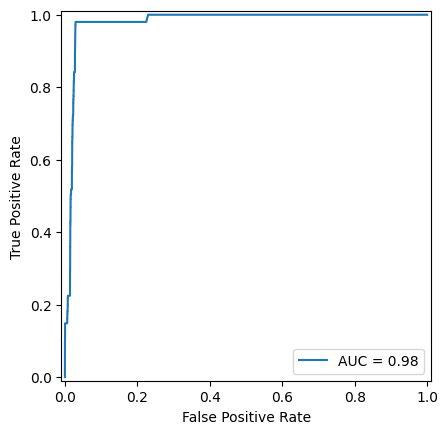

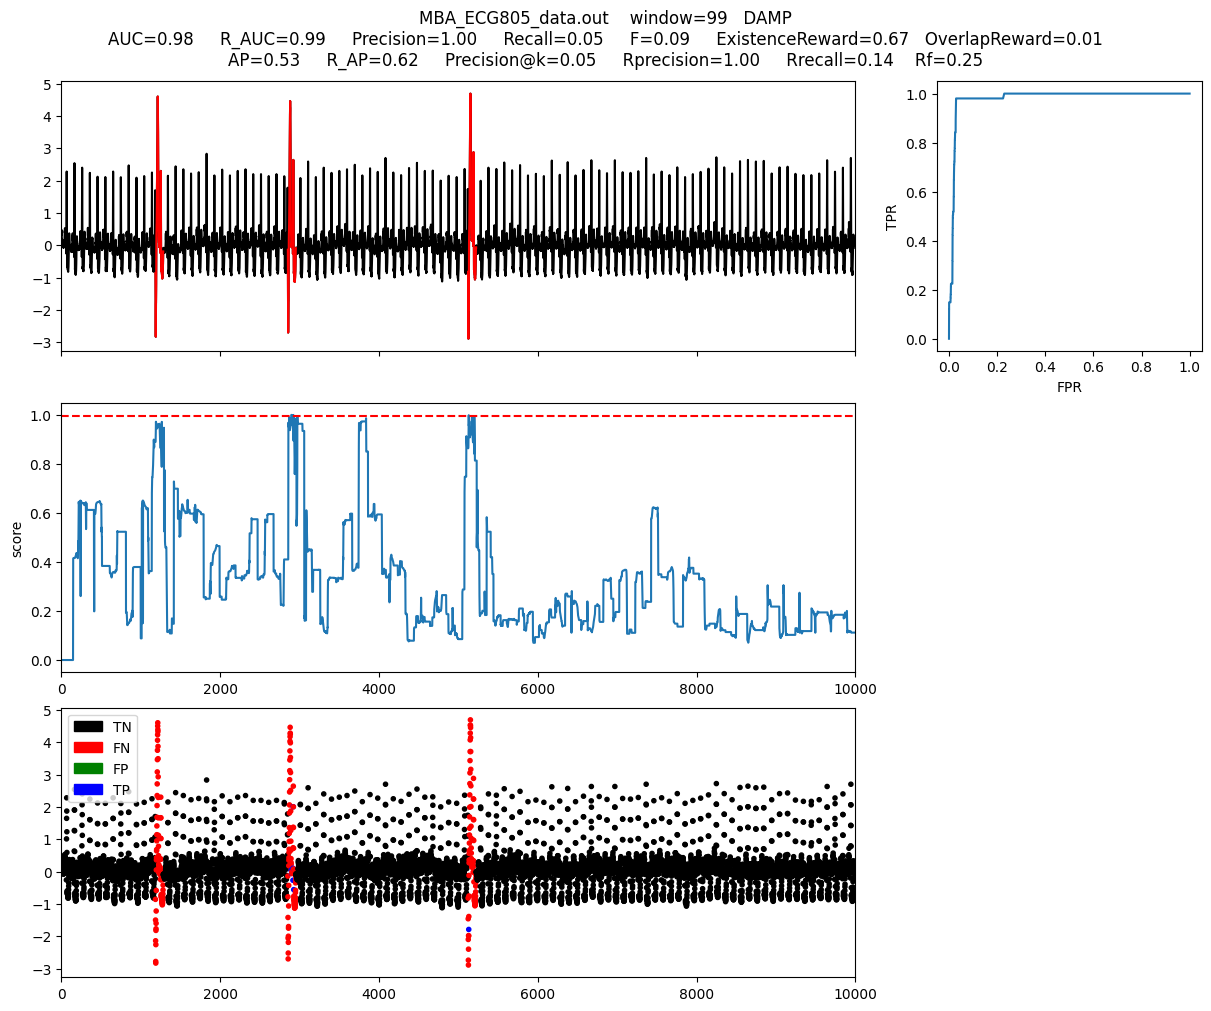

In [18]:
modelName='DAMP'
clf = DAMP(m = slidingWindow,sp_index=slidingWindow+1)
x = data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

1186 1284
2853 2954
5123 5224
1148 1281
2819 2950
5085 5219


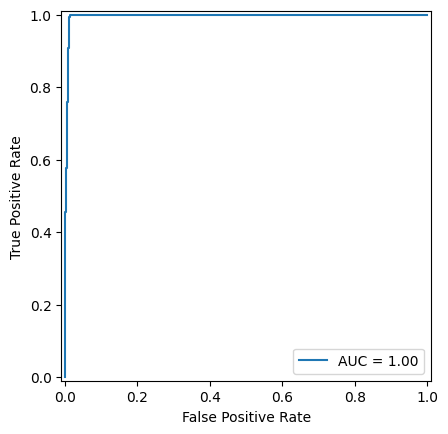

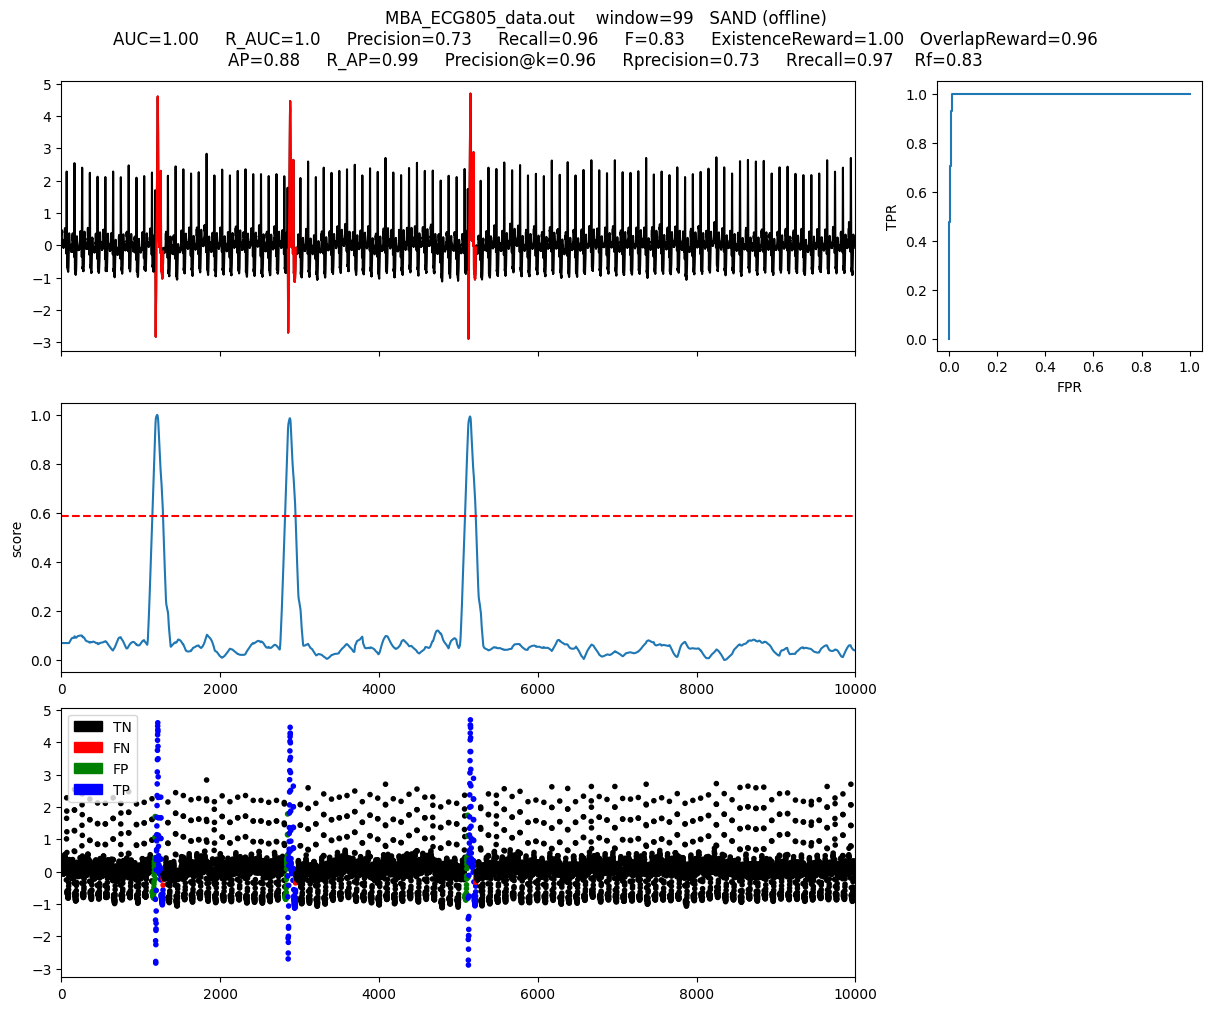

In [12]:
modelName='SAND (offline)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,overlaping_rate=int(1.5*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

0-->5000-->7000-->9000-->[STOP]: score length 10000


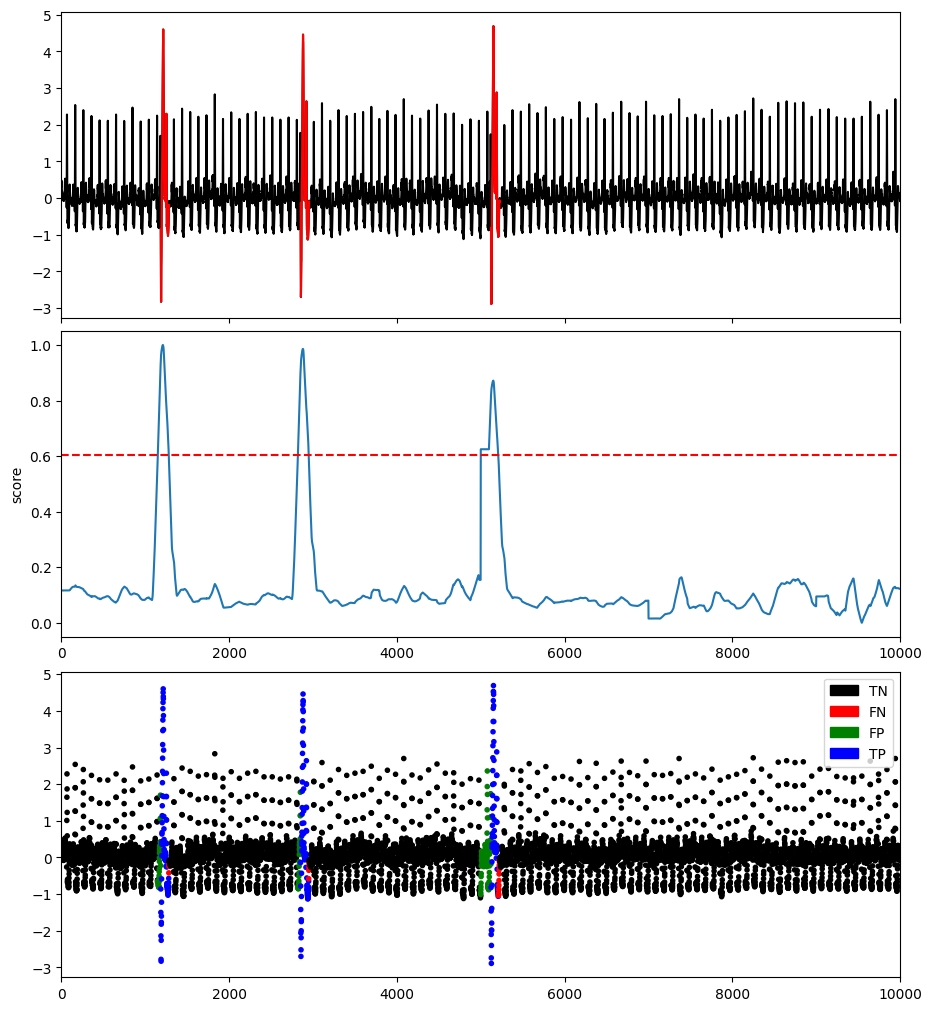

In [8]:
modelName='SAND (online)'
clf = SAND(pattern_length=slidingWindow,subsequence_length=4*(slidingWindow))
x = data
clf.fit(x,online=True,alpha=0.5,init_length=5000,batch_size=2000,verbose=True,overlaping_rate=int(4*slidingWindow))
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

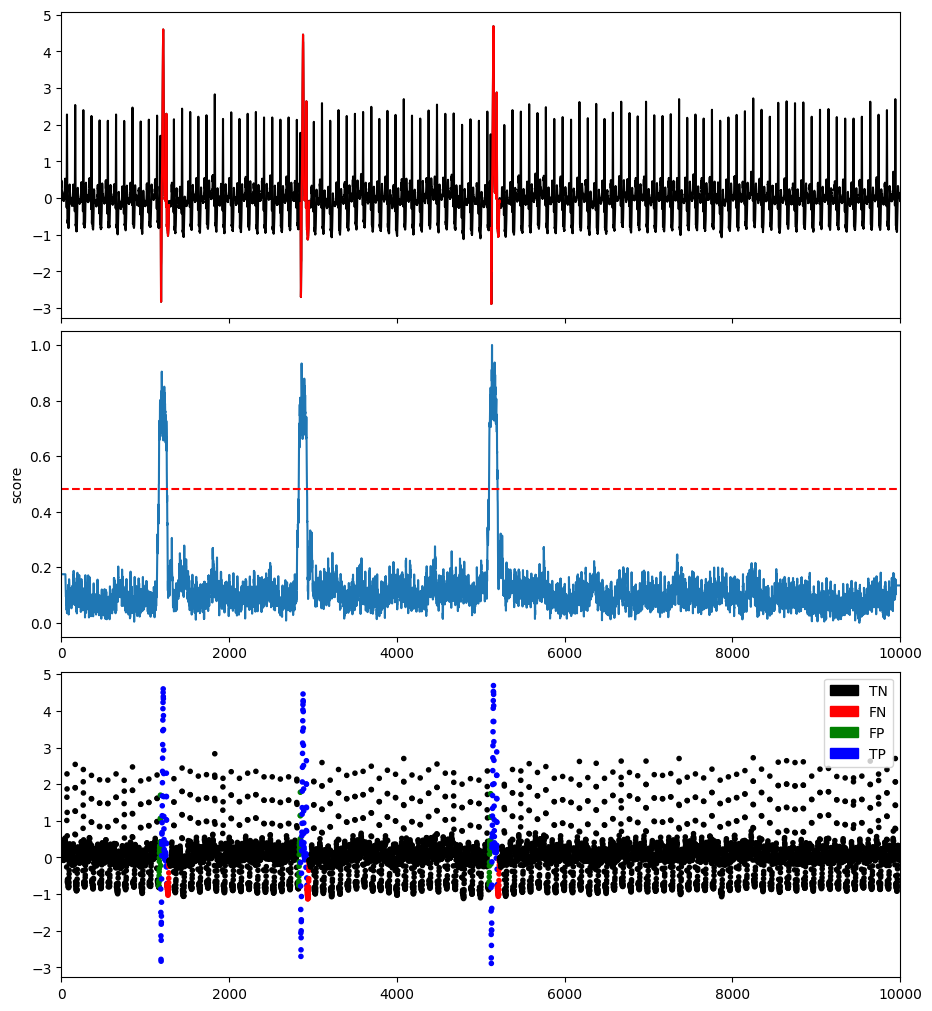

In [9]:
modelName='IForest'
clf = IForest(n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

1186 1284
2853 2954
5123 5224
1133 1158
1268 1281
1291 1327
2801 2826
2935 2946
2948 2949
2951 2953
2959 2971
2973 2976
2988 2994
3741 3741
3746 3748
5070 5095
5205 5264


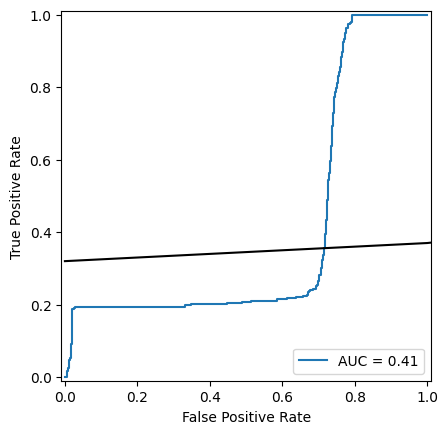

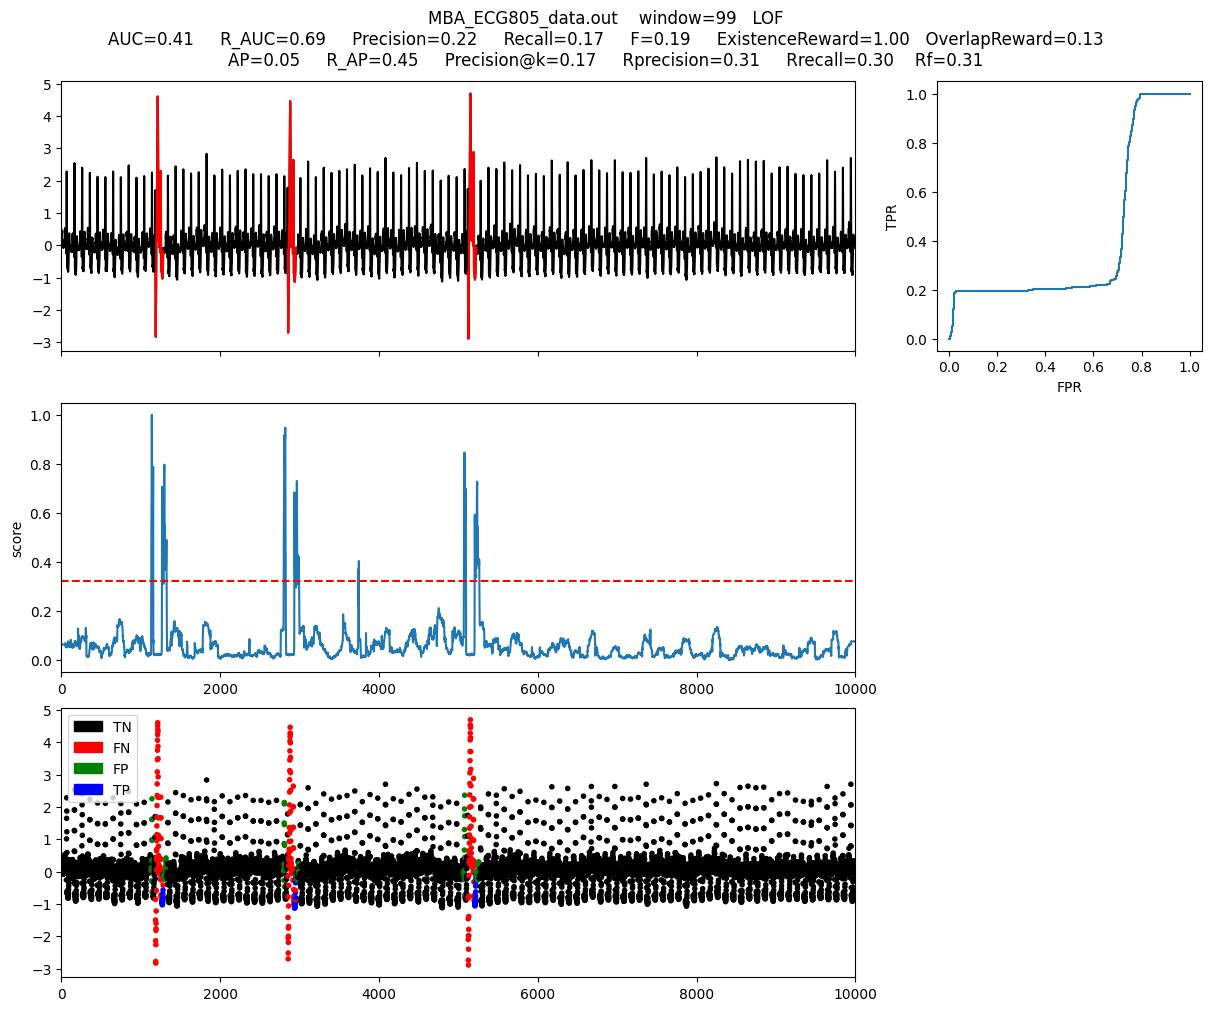

In [3]:
modelName='LOF'
clf = LOF(n_neighbors=20, n_jobs=1)
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) 

In [4]:
modelName='MatrixProfile'
clf = MatrixProfile(window = slidingWindow)
x = data
clf.fit(x)
clf.score(query_length=2*slidingWindow,dataset=x)
score = clf.score
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName) #, plotRange=[1775,2200]

AttributeError: 'MatrixProfile' object has no attribute 'score'

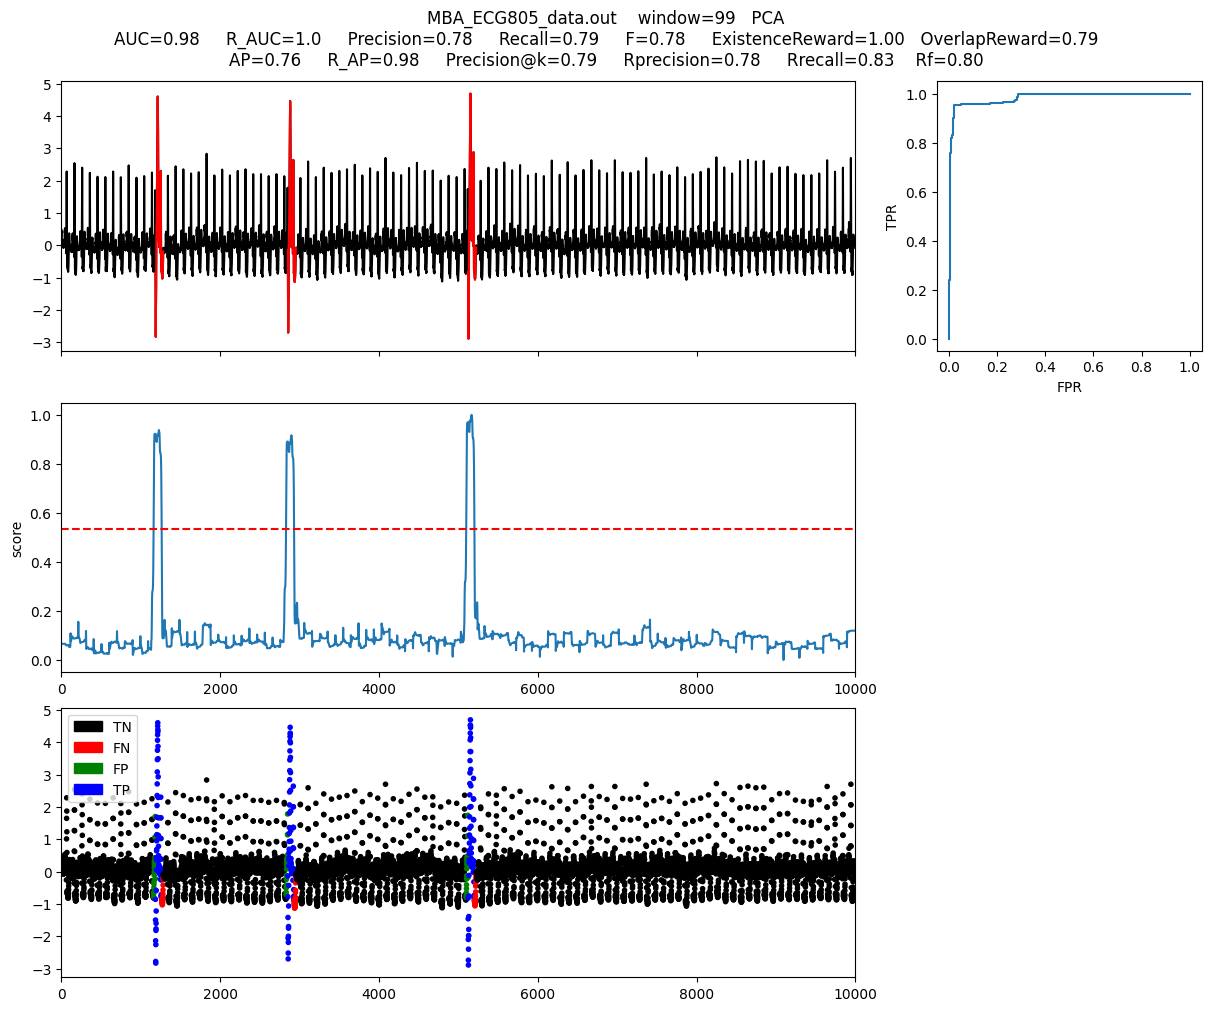

In [8]:
modelName='PCA'
clf = PCA()
x = X_data
clf.fit(x)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

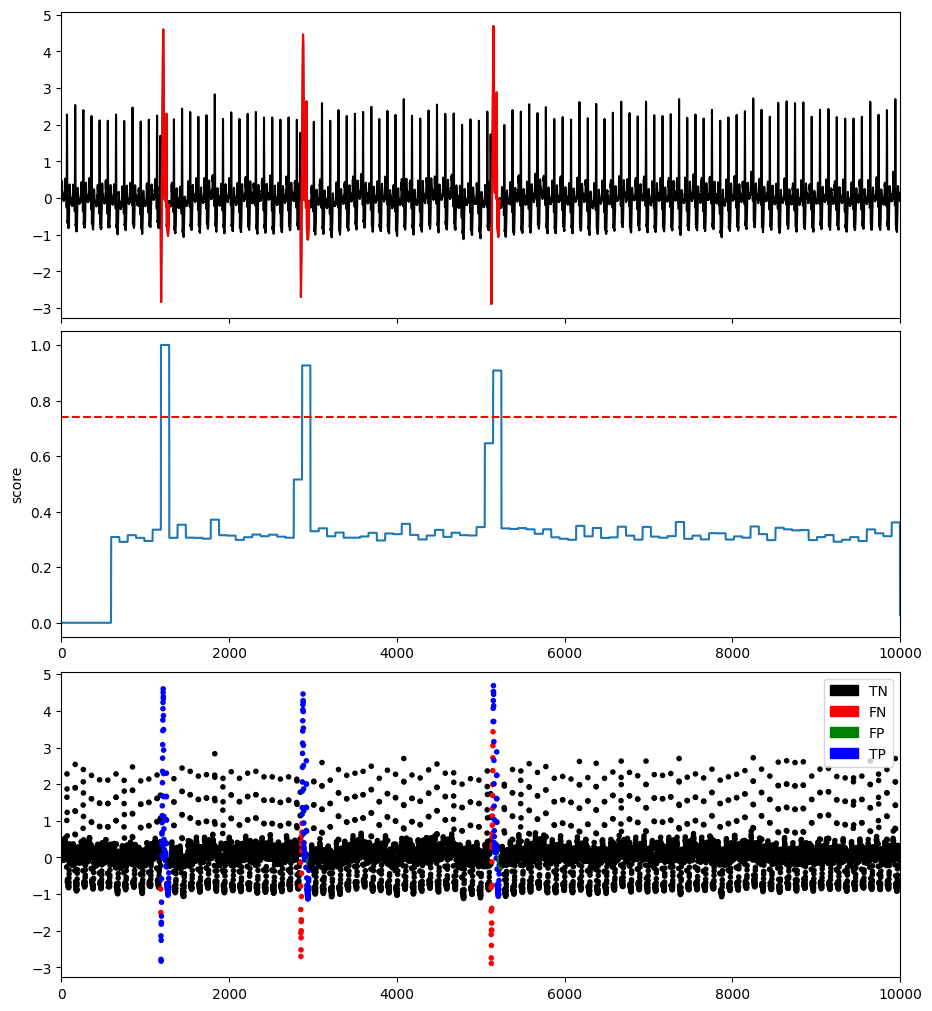

In [12]:
modelName='POLY'
clf = POLY(power=3, window = slidingWindow)
x = data
clf.fit(x)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

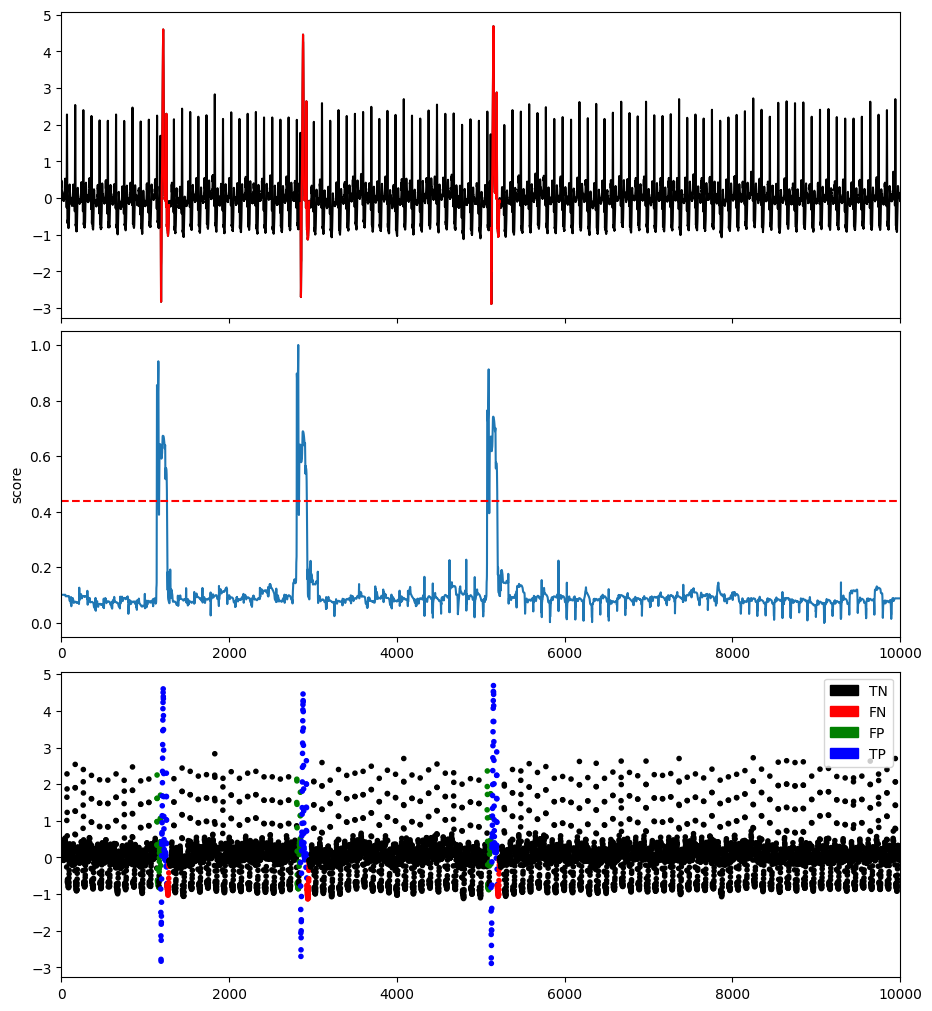

In [13]:
modelName='OCSVM'
X_train_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_train.T).T
X_test_ = MinMaxScaler(feature_range=(0,1)).fit_transform(X_test.T).T

clf = OCSVM(nu=0.05)
clf.fit(X_train_, X_test_)


score = clf.decision_scores_
score = np.array([score[0]]*math.ceil((slidingWindow-1)/2) + list(score) + [score[-1]]*((slidingWindow-1)//2))
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

310/310 [==============================] - 4s 10ms/step


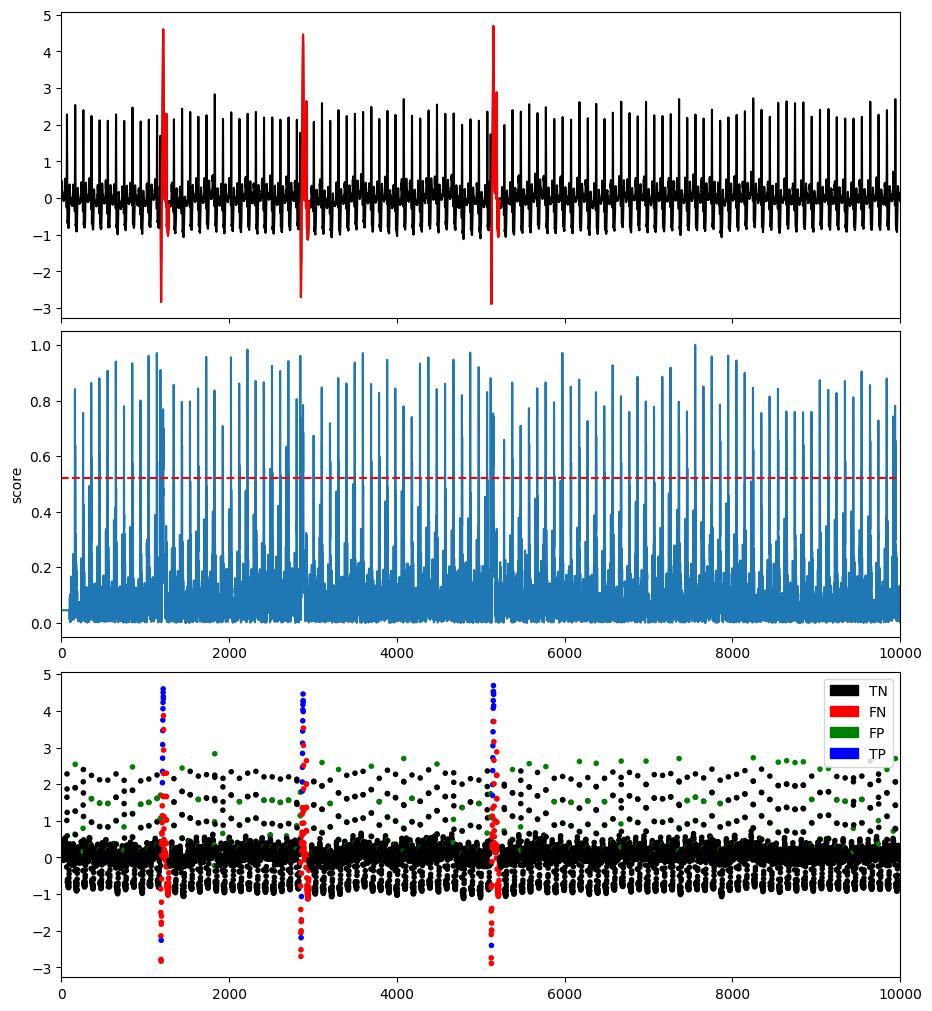

In [14]:
modelName='LSTM'
clf = lstm(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

310/310 [==============================] - 0s 516us/step


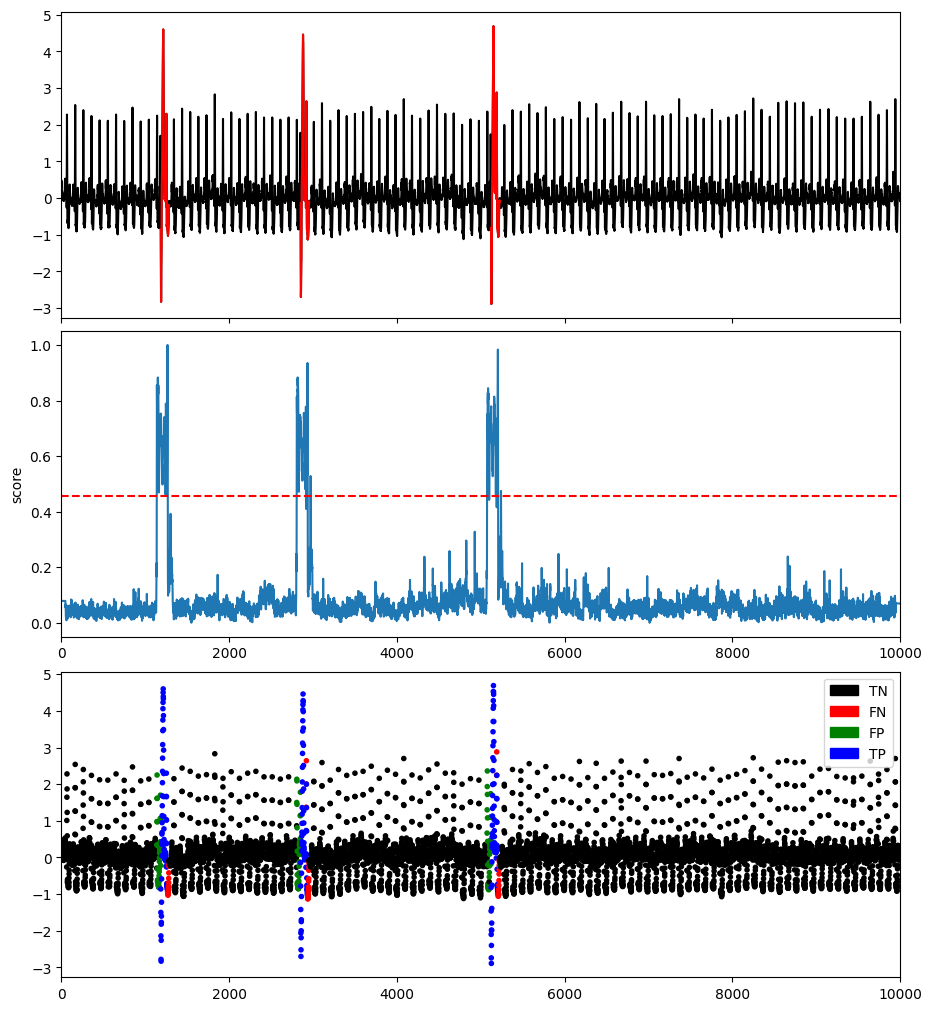

In [15]:
modelName='AE'
clf = AE_MLP2(slidingWindow = slidingWindow, epochs=100, verbose=0)

clf.fit(data_train, data_test)
        
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)

310/310 [==============================] - 0s 909us/step


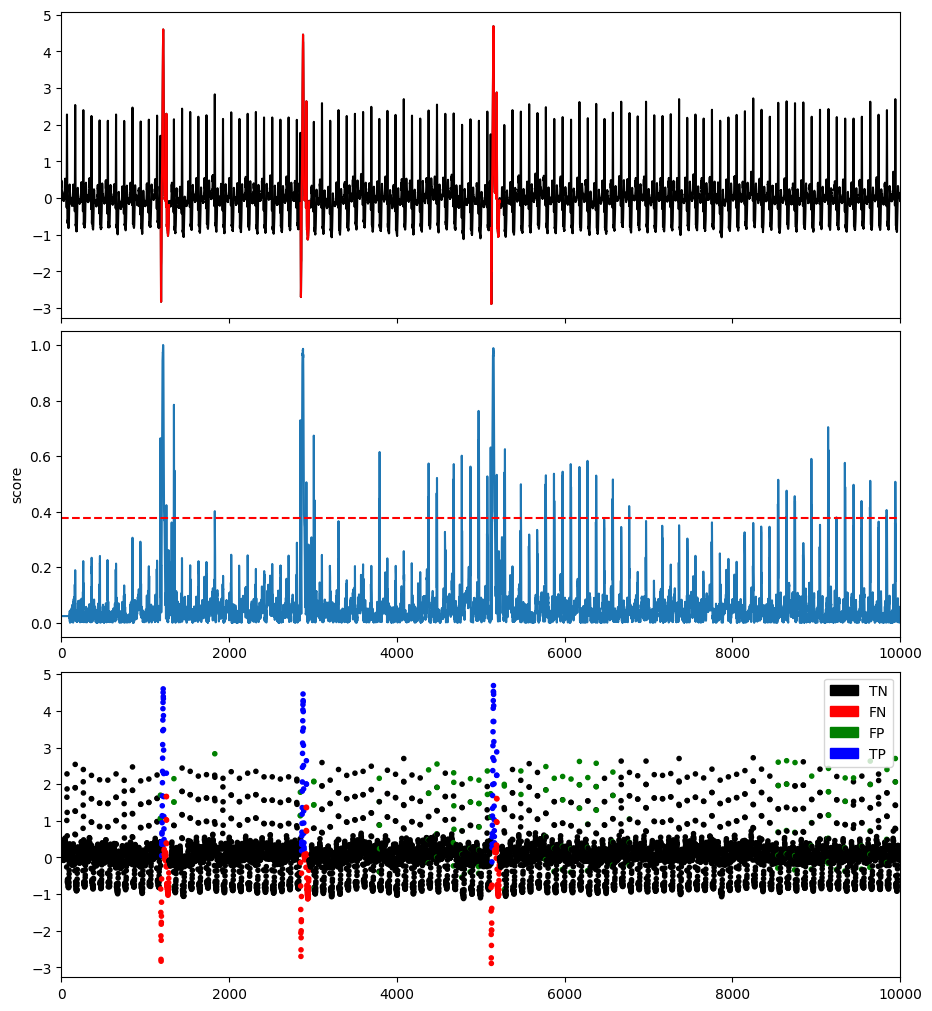

In [16]:
modelName='CNN'
clf = cnn(slidingwindow = slidingWindow, predict_time_steps=1, epochs = 100, patience = 5, verbose=0)

clf.fit(data_train, data_test)
measure = Fourier()
measure.detector = clf
measure.set_param()
clf.decision_function(measure=measure)
score = clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

plotFig(data, label, score, slidingWindow, fileName=name, modelName=modelName)